<a href="https://colab.research.google.com/github/beylo30/MLFP/blob/main/Final_Project_Single_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project — CIFAR-10 CNN (ResNet-style) + SVM Baseline + PCA Visualization

This notebook is a **single-file (.ipynb)** version of the project I uploaded (originally structured as Python modules + `main.py`).

**What it does (in order):**
1. Load CIFAR-10 and create train/val/test splits
2. Build a small ResNet-style CNN with data augmentation
3. Train (with best-checkpoint saving)
4. Evaluate on the official CIFAR-10 test set
5. Print a classification report + plot a confusion matrix
6. Train an SVM baseline on CNN features
7. Create a 3D PCA visualization of extracted features
8. Compare original vs augmented image
9. Predict on an external image URL

Outputs (models/figures/cache) are written under `./outputs/`.

---

## Requirements

These were in the project:

```text
numpy>=1.23
matplotlib>=3.7
tensorflow>=2.9
scikit-learn>=1.2
# Optional (only needed for interactive 3D PCA):
# plotly>=5.0
```

> Note: `requests` is used for downloading external images. If it's missing in your environment, install it (e.g., `pip install requests`).


In [1]:
# --- Setup / Imports ---
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Tuple, List, Optional, Dict, Iterable
import hashlib

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# External image download
try:
    import requests
except Exception as e:
    raise ImportError("This notebook needs `requests` for external image downloading. Install with: pip install requests") from e

print("TensorFlow:", tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices("GPU")) > 0)

# --- Paths ---
PROJECT_ROOT = Path(".").resolve()
OUTPUTS_DIR = PROJECT_ROOT / "outputs"
MODELS_DIR = OUTPUTS_DIR / "models"
FIGURES_DIR = OUTPUTS_DIR / "figures"
URL_CACHE_DIR = OUTPUTS_DIR / "url_cache"
for d in [OUTPUTS_DIR, MODELS_DIR, FIGURES_DIR, URL_CACHE_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# --- Reproducibility ---
def set_reproducibility(seed: int = 42) -> None:
    tf.keras.utils.set_random_seed(seed)
    np.random.seed(seed)

SEED = 42
set_reproducibility(SEED)

TensorFlow: 2.19.0
GPU available: True


## (Definitions) utils.py
The following cell contains the code that originally lived in `src/utils.py`.

In [2]:
import os
from dataclasses import dataclass
from pathlib import Path
from typing import Optional, Sequence

import numpy as np
import tensorflow as tf


@dataclass(frozen=True)
class Paths:
    project_root: Path
    outputs_dir: Path
    models_dir: Path
    figures_dir: Path

    @staticmethod
    def from_root(project_root: Path) -> "Paths":
        outputs_dir = project_root / "outputs"
        models_dir = outputs_dir / "models"
        figures_dir = outputs_dir / "figures"
        models_dir.mkdir(parents=True, exist_ok=True)
        figures_dir.mkdir(parents=True, exist_ok=True)
        return Paths(
            project_root=project_root,
            outputs_dir=outputs_dir,
            models_dir=models_dir,
            figures_dir=figures_dir,
        )


def set_reproducibility(seed: int = 42) -> None:
    """Best-effort reproducibility."""
    tf.keras.utils.set_random_seed(seed)
    np.random.seed(seed)


def gpu_available() -> bool:
    return len(tf.config.list_physical_devices("GPU")) > 0


def ensure_dir(path: Path) -> None:
    path.mkdir(parents=True, exist_ok=True)

## (Definitions) data.py
The following cell contains the code that originally lived in `src/data.py`.

In [3]:
from dataclasses import dataclass
from typing import Tuple, List

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10


@dataclass(frozen=True)
class Cifar10Data:
    X_train: np.ndarray
    y_train: np.ndarray
    X_val: np.ndarray
    y_val: np.ndarray
    X_test: np.ndarray
    y_test: np.ndarray
    classes: List[str]


def load_cifar10(val_split: float = 0.2, seed: int = 42) -> Cifar10Data:
    (X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

    classes = [
        "Airplane", "Automobile", "Bird", "Cat", "Deer",
        "Dog", "Frog", "Horse", "Ship", "Truck"
    ]

    y_train_full = y_train_full.reshape(-1).astype(np.int64)
    y_test = y_test.reshape(-1).astype(np.int64)

    # Train/val split from official training set
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full,
        y_train_full,
        test_size=val_split,
        random_state=seed,
        stratify=y_train_full,
    )

    # Normalize to [0, 1]
    X_train = X_train.astype("float32") / 255.0
    X_val = X_val.astype("float32") / 255.0
    X_test = X_test.astype("float32") / 255.0

    return Cifar10Data(
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        X_test=X_test,
        y_test=y_test,
        classes=classes,
    )


def make_tf_datasets(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    batch_size: int = 128,
    seed: int = 42,
) -> Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
    autotune = tf.data.AUTOTUNE

    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_ds = train_ds.shuffle(20000, seed=seed, reshuffle_each_iteration=True)
    train_ds = train_ds.batch(batch_size).prefetch(autotune)

    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(autotune)
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(autotune)
    return train_ds, val_ds, test_ds

## (Definitions) model.py
The following cell contains the code that originally lived in `src/model.py`.

In [4]:
from dataclasses import dataclass
from typing import Tuple

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers


def build_data_augmentation() -> keras.Sequential:
    return keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomTranslation(0.1, 0.1),
            layers.RandomRotation(0.05),
            layers.RandomZoom(0.1),
        ],
        name="data_augmentation",
    )


def conv_bn_lrelu(x: tf.Tensor, filters: int, k: int = 3, s: int = 1, l2=None) -> tf.Tensor:
    x = layers.Conv2D(
        filters,
        k,
        strides=s,
        padding="same",
        use_bias=False,
        kernel_regularizer=l2,
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)
    return x


def residual_block(x: tf.Tensor, filters: int, downsample: bool = False, l2=None) -> tf.Tensor:
    stride = 2 if downsample else 1
    shortcut = x

    x = conv_bn_lrelu(x, filters, k=3, s=stride, l2=l2)
    x = layers.Conv2D(
        filters,
        3,
        strides=1,
        padding="same",
        use_bias=False,
        kernel_regularizer=l2,
    )(x)
    x = layers.BatchNormalization()(x)

    # Match dimensions for residual add
    if downsample or int(shortcut.shape[-1]) != filters:
        shortcut = layers.Conv2D(
            filters,
            1,
            strides=stride,
            padding="same",
            use_bias=False,
            kernel_regularizer=l2,
        )(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.LeakyReLU(0.1)(x)
    return x


def build_resnet_small(num_classes: int = 10, weight_decay: float = 1e-4) -> keras.Model:
    l2 = regularizers.l2(weight_decay)
    data_aug = build_data_augmentation()

    inputs = keras.Input(shape=(32, 32, 3))
    x = data_aug(inputs)

    # Stem
    x = conv_bn_lrelu(x, 32, l2=l2)
    x = conv_bn_lrelu(x, 32, l2=l2)

    # Stages
    x = residual_block(x, 32, l2=l2)
    x = residual_block(x, 32, l2=l2)

    x = residual_block(x, 64, downsample=True, l2=l2)
    x = residual_block(x, 64, l2=l2)

    x = residual_block(x, 128, downsample=True, l2=l2)
    x = residual_block(x, 128, l2=l2)

    x = residual_block(x, 256, downsample=True, l2=l2)
    x = residual_block(x, 256, l2=l2)

    x = layers.GlobalAveragePooling2D(name="features")(x)
    x = layers.Dropout(0.3)(x)
    logits = layers.Dense(num_classes, name="logits")(x)

    return keras.Model(inputs, logits, name="CIFAR10_ResNetSmall")


def compile_with_cosine_sgd(
    model: keras.Model,
    train_ds: tf.data.Dataset,
    epochs: int,
    initial_lr: float = 0.1,
    momentum: float = 0.9,
) -> None:
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    lr = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=initial_lr,
        decay_steps=steps_per_epoch * epochs,
    )
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=True)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

## (Definitions) train.py
The following cell contains the code that originally lived in `src/train.py`.

In [5]:
from pathlib import Path
from typing import Optional

import tensorflow as tf
from tensorflow import keras


def train(
    model: keras.Model,
    train_ds: tf.data.Dataset,
    val_ds: tf.data.Dataset,
    epochs: int,
    checkpoint_path: Path,
) -> keras.callbacks.History:
    checkpoint_path.parent.mkdir(parents=True, exist_ok=True)

    callbacks = [
        keras.callbacks.ModelCheckpoint(
            str(checkpoint_path),
            monitor="val_accuracy",
            save_best_only=True,
            verbose=1,
        ),
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks,
    )
    return history

## (Definitions) eval.py
The following cell contains the code that originally lived in `src/eval.py`.

In [6]:
from pathlib import Path
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix


def evaluate(model: tf.keras.Model, test_ds: tf.data.Dataset) -> Tuple[float, float]:
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    return float(test_loss), float(test_acc)


def plot_training_curves(history: tf.keras.callbacks.History, save_path: Path | None = None) -> None:
    hist = history.history
    epochs_r = range(1, len(hist["accuracy"]) + 1)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_r, hist["accuracy"], label="Train Acc")
    plt.plot(epochs_r, hist["val_accuracy"], label="Val Acc")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_r, hist["loss"], label="Train Loss")
    plt.plot(epochs_r, hist["val_loss"], label="Val Loss")
    plt.title("Loss")
    plt.legend()

    plt.tight_layout()
    if save_path is not None:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()


def classification_report_and_cm(
    model: tf.keras.Model,
    test_ds: tf.data.Dataset,
    y_test: np.ndarray,
    class_names: List[str],
    save_path: Path | None = None,
) -> np.ndarray:
    y_pred_logits = model.predict(test_ds, verbose=0)
    y_pred = np.argmax(y_pred_logits, axis=1)

    print("\nClassification Report (TEST):")
    print(classification_report(y_test, y_pred, target_names=class_names))

    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, class_names, save_path=save_path)
    return cm


def plot_confusion_matrix(cm: np.ndarray, class_names: List[str], save_path: Path | None = None) -> None:
    plt.figure(figsize=(8, 6))
    plt.imshow(cm)
    plt.title("Confusion Matrix (TEST)")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() * 0.6
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j,
                i,
                cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=8,
            )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    if save_path is not None:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()

## (Definitions) svm_baseline.py
The following cell contains the code that originally lived in `src/svm_baseline.py`.

In [7]:
from dataclasses import dataclass
from typing import Dict, Tuple, Iterable

import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score


@dataclass(frozen=True)
class SvmResult:
    best_params: Dict[str, float]
    val_accuracy: float
    test_accuracy: float


def extract_cnn_features(
    model: tf.keras.Model,
    train_ds_noshuf: tf.data.Dataset,
    val_ds: tf.data.Dataset,
    test_ds: tf.data.Dataset,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    feature_extractor = tf.keras.Model(model.input, model.get_layer("features").output)

    train_features = feature_extractor.predict(train_ds_noshuf, verbose=0)
    val_features = feature_extractor.predict(val_ds, verbose=0)
    test_features = feature_extractor.predict(test_ds, verbose=0)

    train_features = train_features.reshape(train_features.shape[0], -1)
    val_features = val_features.reshape(val_features.shape[0], -1)
    test_features = test_features.reshape(test_features.shape[0], -1)
    return train_features, val_features, test_features


def svm_on_features(
    train_features: np.ndarray,
    y_train: np.ndarray,
    val_features: np.ndarray,
    y_val: np.ndarray,
    test_features: np.ndarray,
    y_test: np.ndarray,
    c_grid: Iterable[float] = (0.1, 1, 3, 10),
) -> SvmResult:
    svm_pipe = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("svm", LinearSVC(dual=False, max_iter=5000)),
        ]
    )

    param_grid = {"svm__C": list(c_grid)}
    grid = GridSearchCV(svm_pipe, param_grid, cv=3, n_jobs=-1, verbose=1)
    grid.fit(train_features, y_train)

    best = grid.best_estimator_

    val_pred = best.predict(val_features)
    val_acc = float(accuracy_score(y_val, val_pred))

    test_pred = best.predict(test_features)
    test_acc = float(accuracy_score(y_test, test_pred))

    return SvmResult(
        best_params=grid.best_params_,
        val_accuracy=val_acc,
        test_accuracy=test_acc,
    )

## (Definitions) viz.py
The following cell contains the code that originally lived in `src/viz.py`.

In [8]:
from pathlib import Path
from typing import Optional

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


def compare_augmentation(data_augmentation, image: np.ndarray, save_path: Path | None = None) -> None:
    import tensorflow as tf

    augmented_image = data_augmentation(tf.expand_dims(image, 0), training=True)[0].numpy()

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(augmented_image)
    plt.title("Augmented")
    plt.axis("off")

    plt.tight_layout()
    if save_path is not None:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()


def pca_3d_plot(features: np.ndarray, labels: np.ndarray, save_path: Path | None = None) -> None:
    """3D PCA scatter plot. Uses Plotly if available, else matplotlib."""
    pca = PCA(n_components=3, random_state=42)
    feat_3d = pca.fit_transform(features)

    # Try Plotly first
    try:
        import plotly.express as px  # type: ignore

        fig = px.scatter_3d(
            x=feat_3d[:, 0],
            y=feat_3d[:, 1],
            z=feat_3d[:, 2],
            color=labels.astype(str),
            title="3D PCA of CNN Features (CIFAR-10)",
            labels={"color": "Class"},
        )
        if save_path is not None:
            # Writes an HTML file if kaleido isn't installed.
            save_path = save_path.with_suffix(".html")
            fig.write_html(str(save_path))
        fig.show()
        return
    except Exception:
        pass

    # Matplotlib fallback
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(feat_3d[:, 0], feat_3d[:, 1], feat_3d[:, 2], c=labels, s=5)
    ax.set_title("3D PCA of CNN Features (CIFAR-10)")

    if save_path is not None:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()

## (Definitions) predict.py
The following cell contains the code that originally lived in `src/predict.py`.

In [9]:
from dataclasses import dataclass
from typing import List, Tuple
from pathlib import Path
import hashlib

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import requests


@dataclass(frozen=True)
class Prediction:
    top_class: str
    top_prob: float
    probs: np.ndarray
    local_path: str  # where the image was saved


def _download_from_url(url: str, prefix: str = "external") -> str:
    """
    Download URL to a unique cached file using a browser-like User-Agent.
    Fixes:
    - caching bug (unique name per URL)
    - 403 forbidden from some websites
    """
    cache_dir = Path("outputs") / "url_cache"
    cache_dir.mkdir(parents=True, exist_ok=True)

    url_hash = hashlib.md5(url.encode("utf-8")).hexdigest()
    local_path = cache_dir / f"{prefix}_{url_hash}.jpg"

    # if already downloaded, reuse
    if local_path.exists() and local_path.stat().st_size > 0:
        return str(local_path)

    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/120.0 Safari/537.36"
        )
    }
    r = requests.get(url, headers=headers, timeout=30, stream=True)
    r.raise_for_status()

    with open(local_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024 * 256):
            if chunk:
                f.write(chunk)

    return str(local_path)


def predict_image_from_url(
    model: tf.keras.Model,
    url: str,
    class_names: List[str],
    target_size: Tuple[int, int] = (32, 32),
) -> Prediction:
    local_path = _download_from_url(url, prefix="external_img")

    # model input (32x32)
    img_32 = keras.utils.load_img(local_path, target_size=target_size)
    x = keras.utils.img_to_array(img_32).astype("float32") / 255.0
    x = tf.expand_dims(x, 0)  # (1, 32, 32, 3)

    raw = model.predict(x, verbose=0)[0]
    raw = np.asarray(raw)

    # probabilities safely (softmax only if needed)
    if (raw.min() >= 0.0) and (raw.max() <= 1.0) and np.isclose(raw.sum(), 1.0, atol=1e-3):
        probs = raw
    else:
        probs = tf.nn.softmax(raw).numpy()

    top = int(np.argmax(probs))
    return Prediction(
        top_class=class_names[top],
        top_prob=float(probs[top]),
        probs=probs,
        local_path=local_path,
    )


def show_downloaded_and_model_input(local_path: str, title: str = "") -> None:
    """
    Show:
    - left: downloaded image (original size)
    - right: model input (32x32)
    """
    img_full = keras.utils.load_img(local_path)
    img_32 = keras.utils.load_img(local_path, target_size=(32, 32))

    plt.figure(figsize=(7, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(img_full)
    plt.title("Downloaded image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img_32)
    plt.title(title if title else "Model input (32x32)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

def show_image_from_url(url: str, title: str) -> None:
    local_path = _download_from_url(url, prefix="external_img_vis")
    show_downloaded_and_model_input(local_path, title=title)

## Run the pipeline

In [10]:
# --- 1) Load CIFAR-10 + create tf.data pipelines ---

data = load_cifar10(val_split=0.2, seed=SEED)
train_ds, val_ds, test_ds = make_tf_datasets(
    data.X_train, data.y_train,
    data.X_val, data.y_val,
    data.X_test, data.y_test,
    batch_size=128,
    seed=SEED,
)

print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Val batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())
print("Classes:", data.classes)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step
Train batches: 313
Val batches: 79
Test batches: 79
Classes: ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


In [11]:
# --- 2) Build and compile the CNN (ResNet-style) ---
model = build_resnet_small(num_classes=len(data.classes))
compile_with_cosine_sgd(model, train_ds=train_ds, epochs=10, initial_lr=0.1, momentum=0.9)
model.summary()

Model: "CIFAR10_ResNetSmall"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 32, 32, 3) │          0 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        864 │ data_augmentatio… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      9,216 │ leaky_re_lu[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      9,216 │ leaky_re_lu_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      9,216 │ leaky_re_lu_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      9,216 │ leaky_re_lu_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_4[0][0]  

 Total params: 2,811,754 (10.73 MB)

 Trainable params: 2,806,890 (10.71 MB)

 Non-trainable params: 4,864 (19.00 KB)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.2661 - loss: 2.4866
Epoch 1: val_accuracy improved from -inf to 0.36670, saving model to /content/outputs/models/best_cifar10_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - accuracy: 0.2663 - loss: 2.4854 - val_accuracy: 0.3667 - val_loss: 1.9113
Epoch 2/10
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4358 - loss: 1.7599
Epoch 2: val_accuracy improved from 0.36670 to 0.46820, saving model to /content/outputs/models/best_cifar10_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.4359 - loss: 1.7596 - val_accuracy: 0.4682 - val_loss: 1.7002
Epoch 3/10
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5195 - loss: 1.5523
Epoch 3: val_accuracy improved from 0.46820 to 0.55410, saving model to /content/outputs/models/best_cifar10_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.5196 - loss: 1.5520 - val_accuracy: 0.5541 - val_loss: 1.5151
Epoch 4/10
312/313 ━━━

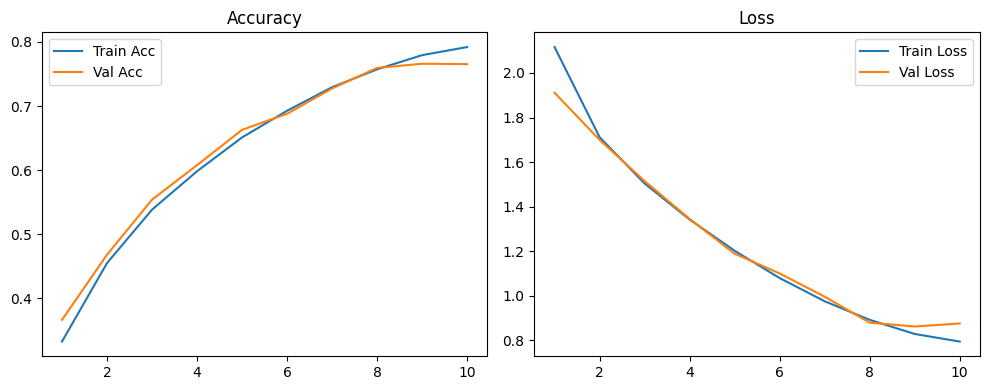

In [12]:
# --- 3) Train (saves best checkpoint to outputs/models/) ---
EPOCHS = 10
MODEL_PATH = MODELS_DIR / "best_cifar10_model.keras"

history = train(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    epochs=EPOCHS,
    checkpoint_path=MODEL_PATH,
)

best_model = keras.models.load_model(MODEL_PATH)
print("Loaded best model from:", MODEL_PATH)

plot_training_curves(history, save_path=FIGURES_DIR / "training_curves.png")

In [13]:
# --- 4) Evaluate on official CIFAR-10 test set ---
test_loss, test_acc = evaluate(best_model, test_ds)
print(f"Official TEST accuracy: {test_acc:.4f} (loss={test_loss:.4f})")

Official TEST accuracy: 0.7603 (loss=0.8948)



Classification Report (TEST):
              precision    recall  f1-score   support

    Airplane       0.74      0.85      0.79      1000
  Automobile       0.87      0.90      0.89      1000
        Bird       0.82      0.54      0.65      1000
         Cat       0.68      0.52      0.59      1000
        Deer       0.78      0.67      0.72      1000
         Dog       0.75      0.60      0.67      1000
        Frog       0.58      0.93      0.72      1000
       Horse       0.79      0.85      0.82      1000
        Ship       0.93      0.82      0.87      1000
       Truck       0.77      0.91      0.83      1000

    accuracy                           0.76     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.77      0.76      0.76     10000



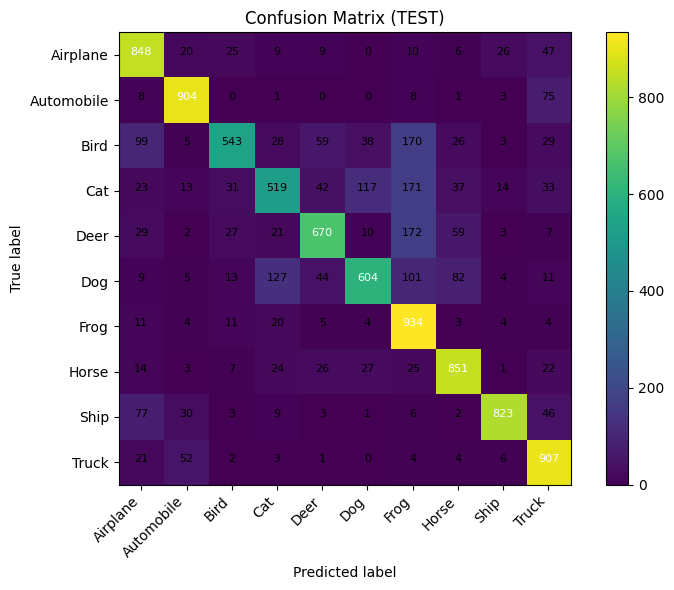

Saved confusion matrix to: /content/outputs/figures/confusion_matrix.png


In [14]:
# --- 5) Classification report + confusion matrix ---
cm = classification_report_and_cm(
    model=best_model,
    test_ds=test_ds,
    y_test=data.y_test,
    class_names=data.classes,
    save_path=FIGURES_DIR / "confusion_matrix.png",
)
print("Saved confusion matrix to:", FIGURES_DIR / "confusion_matrix.png")

In [15]:
# --- 6) SVM baseline on CNN features ---

# For the training features, don't shuffle so labels align.
autotune = tf.data.AUTOTUNE
train_ds_noshuf = (
    tf.data.Dataset.from_tensor_slices((data.X_train, data.y_train))
    .batch(128)
    .prefetch(autotune)
)

train_f, val_f, test_f = extract_cnn_features(best_model, train_ds_noshuf, val_ds, test_ds)
svm_res = svm_on_features(
    train_features=train_f,
    y_train=data.y_train,
    val_features=val_f,
    y_val=data.y_val,
    test_features=test_f,
    y_test=data.y_test,
    c_grid=(0.1, 1, 3, 10),
)

print("SVM baseline results:")
print(" - best params:", svm_res.best_params)
print(f" - val accuracy:  {svm_res.val_accuracy:.4f}")
print(f" - test accuracy: {svm_res.test_accuracy:.4f}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
SVM baseline results:
 - best params: {'svm__C': 0.1}
 - val accuracy:  0.8090
 - test accuracy: 0.8017


In [16]:
# --- 7) 3D PCA visualization (subset of train features) ---
PCA_N = 6000
n = min(PCA_N, train_f.shape[0])
rng = np.random.RandomState(42)
idx = rng.choice(train_f.shape[0], size=n, replace=False)

pca_3d_plot(train_f[idx], data.y_train[idx], save_path=FIGURES_DIR / "pca_3d.png")
print("Saved PCA plot to:", (FIGURES_DIR / "pca_3d.png"))

Saved PCA plot to: /content/outputs/figures/pca_3d.png


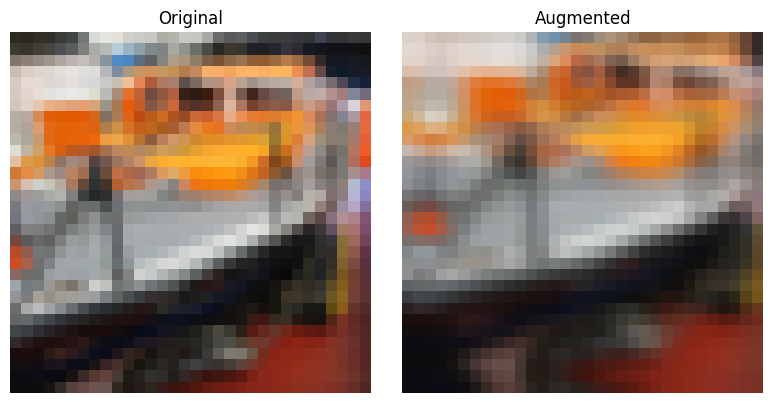

Saved augmentation comparison to: /content/outputs/figures/augmentation_compare.png


In [17]:
# --- 8) Compare original vs augmented image ---
AUG_INDEX = 56
aug = build_data_augmentation()
img = data.X_train[AUG_INDEX]
compare_augmentation(aug, img, save_path=FIGURES_DIR / "augmentation_compare.png")
print("Saved augmentation comparison to:", FIGURES_DIR / "augmentation_compare.png")

External image prediction: Automobile (94.35%)


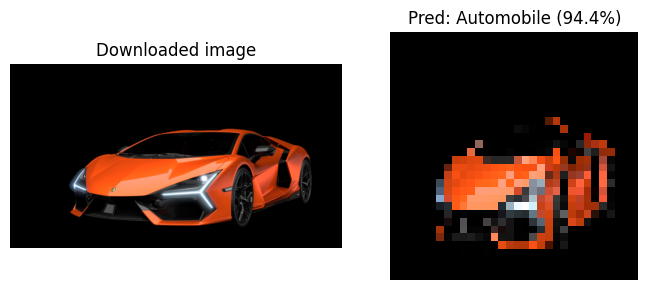

In [18]:
# --- 9) Predict an external image URL ---
DEFAULT_EXTERNAL_URL = (
    "https://www.lamborghini.com/sites/it-en/files/DAM/lamborghini/"
    "facelift_2019/homepage/families-gallery/2023/revuelto/revuelto_m.png"
)

url = DEFAULT_EXTERNAL_URL
pred = predict_image_from_url(best_model, url, class_names=data.classes)
print(f"External image prediction: {pred.top_class} ({pred.top_prob*100:.2f}%)")
show_downloaded_and_model_input(pred.local_path, title=f"Pred: {pred.top_class} ({pred.top_prob*100:.1f}%)")

## Notes
- If training takes too long, reduce `EPOCHS` or increase `batch_size`.
- All generated files are saved under `outputs/`.